<a href="https://colab.research.google.com/github/suprabhathk/FoundationalModels_TimeSeries_Epidemics/blob/main/TabPFN_FoundationModels_Workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Reference demo for TabPFN - [TabPFN_Demo](https://colab.research.google.com/github/liam-sbhoo/tabpfn-time-series/blob/main/demo.ipynb#scrollTo=_EJU0ILwHS_5)

Importing dependencies

In [3]:
!pip install tabpfn-time-series

In [4]:
# for downloading datasets
!pip install datasets

## **1. Loading the timeseries dataset from Influcast**

In [5]:
# Importing dependencies for data import
import pandas as pd
import requests
from io import StringIO

In [6]:
def get_last_available_week_data(year):
    """
    Try to get the last available weekly data for a season by checking weeks in reverse order
    """
    base_url = "https://raw.githubusercontent.com/Predizioni-Epidemiologiche-Italia/Influcast/main/sorveglianza/ILI"
    season = f"{year}-{year+1}"

    # Try weeks in reverse order for the second year (most likely to have the final data)
    for week in range(20, 0, -1):  # Try weeks 20 down to 1
        file_name = f"italia-{year+1}_{week:02d}-ILI.csv"
        url = f"{base_url}/{season}/{file_name}"

        try:
            df = pd.read_csv(url)
            print(f"Found data for {season} at week {week} of {year+1}")
            return df
        except:
            continue

    # If not found, try end weeks of first year
    for week in range(53, 39, -1):  # Try weeks 53 down to 40
        file_name = f"italia-{year}_{week:02d}-ILI.csv"
        url = f"{base_url}/{season}/{file_name}"

        try:
            df = pd.read_csv(url)
            print(f"Found data for {season} at week {week} of {year}")
            return df
        except:
            continue

    print(f"No data found for season {season}")
    return None

In [7]:
def get_latest_data(year):
    """Helper function to get latest format data (for 2023 onwards)"""
    base_url = "https://raw.githubusercontent.com/Predizioni-Epidemiologiche-Italia/Influcast/main/sorveglianza/ILI"
    season = f"{year}-{year+1}"
    url = f"{base_url}/{season}/latest/italia-latest-ILI.csv"

    try:
        df = pd.read_csv(url)
        return df
    except Exception as e:
        print(f"Error importing {season}: {str(e)}")
        return None


In [8]:
def import_flu_data(start_year=2003, end_year=2024):
    """
    Import flu data from GitHub repository:
    - For 2003-2022: Gets last available weekly data
    - For 2023 onwards: Gets latest format data
    """
    all_dfs = []

    # Handle older years (2003-2022)
    for year in range(start_year, 2023):
        print(f"\nProcessing {year}-{year+1} season...")
        df = get_last_available_week_data(year)
        if df is not None:
            print(f"Entries found: {len(df)}")
            all_dfs.append(df)

    # Handle newer years with latest format (2023-2025)
    for year in range(2023, end_year + 1):
        print(f"\nProcessing {year}-{year+1} season (latest format)...")
        df = get_latest_data(year)
        if df is not None:
            print(f"Entries found: {len(df)}")
            all_dfs.append(df)

    # Combine all data
    if all_dfs:
        combined_df = pd.concat(all_dfs, ignore_index=True)
        print(f"\nFinal dataset shape: {combined_df.shape}")
        return combined_df
    else:
        raise ValueError("No data was successfully imported")

In [9]:
# Import all data
try:
    df_influcast = import_flu_data()
except Exception as e:
    print(f"Error: {str(e)}")


Processing 2003-2004 season...
Found data for 2003-2004 at week 17 of 2004
Entries found: 28

Processing 2004-2005 season...
Found data for 2004-2005 at week 16 of 2005
Entries found: 28

Processing 2005-2006 season...
Found data for 2005-2006 at week 17 of 2006
Entries found: 28

Processing 2006-2007 season...
Found data for 2006-2007 at week 17 of 2007
Entries found: 28

Processing 2007-2008 season...
Found data for 2007-2008 at week 17 of 2008
Entries found: 28

Processing 2008-2009 season...
Found data for 2008-2009 at week 17 of 2009
Entries found: 28

Processing 2009-2010 season...
Found data for 2009-2010 at week 15 of 2010
Entries found: 27

Processing 2010-2011 season...
Found data for 2010-2011 at week 17 of 2011
Entries found: 28

Processing 2011-2012 season...
Found data for 2011-2012 at week 17 of 2012
Entries found: 28

Processing 2012-2013 season...
Found data for 2012-2013 at week 17 of 2013
Entries found: 28

Processing 2013-2014 season...
Found data for 2013-2014 at 

In [10]:
df_influcast

,anno,settimana,incidenza,numero_casi,numero_assistiti,target
0,2003,42,0.360000,357,1000656,ILI
1,2003,43,0.470000,500,1066723,ILI
2,2003,44,0.520000,597,1150866,ILI
3,2003,45,0.600000,723,1204797,ILI
4,2003,46,0.590000,742,1251026,ILI
...,...,...,...,...,...,...
597,2024,52,10.507239,23238,2211618,ILI
598,2025,1,12.355276,27339,2212739,ILI
599,2025,2,14.768421,32995,2234159,ILI
600,2025,3,15.888903,33734,2123117,ILI


### **1.1 Converting it into a tabPFN friendly format**

In [11]:
df_ts = df_influcast.copy()
df_ts['timestamp'] = pd.to_datetime(df_ts['anno'].astype(str) + '-' + df_ts['settimana'].astype(str) + '-1', format='%Y-%W-%w').dt.to_period('W').dt.to_timestamp()
df_ts = df_ts[['timestamp', 'incidenza']].rename(columns={'incidenza': 'target'})
df_ts['item_id'] = 'ILI'

df_ts

,timestamp,target,item_id
0,2003-10-20,0.360000,ILI
1,2003-10-27,0.470000,ILI
2,2003-11-03,0.520000,ILI
3,2003-11-10,0.600000,ILI
4,2003-11-17,0.590000,ILI
...,...,...,...
597,2024-12-23,10.507239,ILI
598,2025-01-06,12.355276,ILI
599,2025-01-13,14.768421,ILI
600,2025-01-20,15.888903,ILI


In [12]:
!pip install --upgrade gluonts

In [13]:
from autogluon.timeseries import TimeSeriesDataFrame
from tabpfn_time_series.data_preparation import to_gluonts_univariate, generate_test_X


In [14]:
import numpy as np

### ***We adapt generate_test_X based on the kind of prediction_length we are looking at (Weekly, Daily, Monthly or Yearly)***

In [16]:
def generate_test_X(train_tsdf, prediction_length, freq='W'):
    test_dfs = []
    for item_id in train_tsdf.item_ids:
        ground_truth_timestamps = test_tsdf_ground_truth.xs(item_id, level="item_id").index
        test_dfs.append(
            pd.DataFrame({
                "target": np.full(prediction_length, np.nan),
                "timestamp": ground_truth_timestamps[-prediction_length:],
                "item_id": item_id,
            })
        )
    return TimeSeriesDataFrame.from_data_frame(pd.concat(test_dfs))

## 1.2 Building timeseries dataframe for downstream analysis

In [47]:
prediction_length = 4
tsdf = TimeSeriesDataFrame(df_ts)
train_tsdf, test_tsdf_ground_truth = tsdf.train_test_split(prediction_length=prediction_length)
test_tsdf = generate_test_X(train_tsdf, prediction_length)

In [48]:
train_tsdf

target
item_id timestamp            
ILI     2003-10-20   0.360000
        2003-10-27   0.470000
        2003-11-03   0.520000
        2003-11-10   0.600000
        2003-11-17   0.590000
...                       ...
        2024-11-25   8.618092
        2024-12-02   9.092945
        2024-12-09  10.165099
        2024-12-16  10.738885
        2024-12-23  10.507239

[598 rows x 1 columns]

In [49]:
test_tsdf

target
item_id timestamp         
ILI     2025-01-06     NaN
        2025-01-13     NaN
        2025-01-20     NaN
        2025-01-27     NaN

In [50]:
print("Test predictions start date:", test_tsdf.index.get_level_values('timestamp')[0])
print("Test predictions end date:", test_tsdf.index.get_level_values('timestamp')[-1])

Test predictions start date: 2025-01-06 00:00:00
Test predictions end date: 2025-01-27 00:00:00


In [51]:
test_tsdf_ground_truth

target
item_id timestamp            
ILI     2003-10-20   0.360000
        2003-10-27   0.470000
        2003-11-03   0.520000
        2003-11-10   0.600000
        2003-11-17   0.590000
...                       ...
        2024-12-23  10.507239
        2025-01-06  12.355276
        2025-01-13  14.768421
        2025-01-20  15.888903
        2025-01-27  17.310525

[602 rows x 1 columns]

Visualising the timeseries

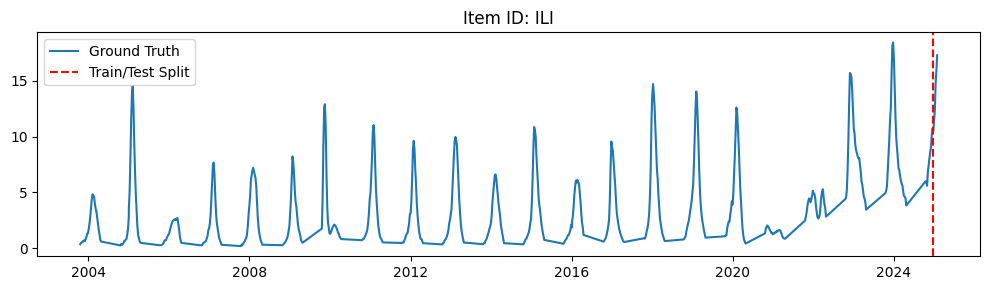

In [52]:
from tabpfn_time_series.plot import plot_actual_ts

plot_actual_ts(train_tsdf, test_tsdf_ground_truth)

## **2. Adding features (sine,cosine)**

In [53]:
from tabpfn_time_series import FeatureTransformer, DefaultFeatures

selected_features = [
    DefaultFeatures.add_running_index,
    DefaultFeatures.add_calendar_features,
]

train_tsdf, test_tsdf = FeatureTransformer.add_features(
    train_tsdf, test_tsdf, selected_features
)


In [54]:
train_tsdf.head()

target  running_index  year  hour_of_day_sin  \
item_id timestamp                                                  
ILI     2003-10-20    0.36              0  2003              0.0   
        2003-10-27    0.47              1  2003              0.0   
        2003-11-03    0.52              2  2003              0.0   
        2003-11-10    0.60              3  2003              0.0   
        2003-11-17    0.59              4  2003              0.0   

                    hour_of_day_cos  day_of_week_sin  day_of_week_cos  \
item_id timestamp                                                       
ILI     2003-10-20              1.0              0.0              1.0   
        2003-10-27              1.0              0.0              1.0   
        2003-11-03              1.0              0.0              1.0   
        2003-11-10              1.0              0.0              1.0   
        2003-11-17              1.0              0.0              1.0   

                    day_of_month_sin  day_of_month_cos  day_of_year_sin  \
item_id timestamp                                                         
ILI     2003-10-20         -0.786552         -0.617525        -0.946699   
        2003-10-27         -0.678312          0.734774        -0.900969   
        2003-11-03          0.413212          0.910635        -0.842101   
        2003-11-10          0.940700         -0.339239        -0.770953   
        2003-11-17         -0.263103         -0.964768        -0.688563   

                    day_of_year_cos  week_of_year_sin  week_of_year_cos  \
item_id timestamp                                                         
ILI     2003-10-20         0.322120         -0.895163          0.445738   
        2003-10-27         0.433884         -0.833602          0.552365   
        2003-11-03         0.539320         -0.759405          0.650618   
        2003-11-10         0.636892         -0.673696          0.739009   
        2003-11-17         0.725176         -0.577774          0.816197   

                    month_of_year_sin  month_of_year_cos  
item_id timestamp                                         
ILI     2003-10-20          -0.909632           0.415415  
        2003-10-27          -0.909632           0.415415  
        2003-11-03          -0.540641           0.841254  
        2003-11-10          -0.540641           0.841254  
        2003-11-17          -0.540641           0.841254

In [55]:
test_tsdf.head()

target  running_index  year  hour_of_day_sin  \
item_id timestamp                                                  
ILI     2025-01-06     NaN            598  2025              0.0   
        2025-01-13     NaN            599  2025              0.0   
        2025-01-20     NaN            600  2025              0.0   
        2025-01-27     NaN            601  2025              0.0   

                    hour_of_day_cos  day_of_week_sin  day_of_week_cos  \
item_id timestamp                                                       
ILI     2025-01-06              1.0              0.0              1.0   
        2025-01-13              1.0              0.0              1.0   
        2025-01-20              1.0              0.0              1.0   
        2025-01-27              1.0              0.0              1.0   

                    day_of_month_sin  day_of_month_cos  day_of_year_sin  \
item_id timestamp                                                         
ILI     2025-01-06          0.874763          0.484551         0.086200   
        2025-01-13          0.552800         -0.833314         0.205660   
        2025-01-20         -0.786552         -0.617525         0.322120   
        2025-01-27         -0.678312          0.734774         0.433884   

                    day_of_year_cos  week_of_year_sin  week_of_year_cos  \
item_id timestamp                                                         
ILI     2025-01-06         0.996278          0.122888          0.992421   
        2025-01-13         0.978624          0.243914          0.969797   
        2025-01-20         0.946699          0.361242          0.932472   
        2025-01-27         0.900969          0.473094          0.881012   

                    month_of_year_sin  month_of_year_cos  
item_id timestamp                                         
ILI     2025-01-06                0.0                1.0  
        2025-01-13                0.0                1.0  
        2025-01-20                0.0                1.0  
        2025-01-27                0.0                1.0

## **3. Prediction**

In [56]:
from tabpfn_time_series import TabPFNTimeSeriesPredictor, TabPFNMode

predictor = TabPFNTimeSeriesPredictor(
    tabpfn_mode=TabPFNMode.CLIENT,
)

pred = predictor.predict(train_tsdf, test_tsdf)

## **4. Visualise the results**

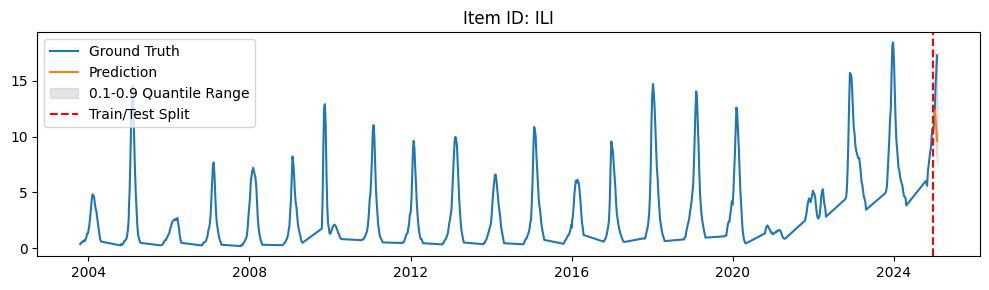

In [57]:
from tabpfn_time_series.plot import plot_pred_and_actual_ts

plot_pred_and_actual_ts(
    train=train_tsdf,
    test=test_tsdf_ground_truth,
    pred=pred,
)

In [58]:
pred.head()

target       0.1        0.2        0.3        0.4  \
item_id timestamp                                                          
ILI     2025-01-06  12.358497  9.705025  10.510999  11.142584  11.737452   
        2025-01-13  11.557237  9.097074   9.892381  10.451496  11.002986   
        2025-01-20  10.650946  8.339565   9.118047   9.634325  10.124723   
        2025-01-27   9.615768  7.564739   8.291844   8.771029   9.175218   

                          0.5        0.6        0.7        0.8        0.9  
item_id timestamp                                                          
ILI     2025-01-06  12.358497  13.084096  14.051464  15.487635  17.765560  
        2025-01-13  11.557237  12.196559  12.976480  14.163547  16.601660  
        2025-01-20  10.650946  11.303409  12.159774  13.424764  16.206022  
        2025-01-27   9.615768  10.194099  11.141769  12.714414  15.810415

In [59]:
# Extract ground truth values for the predicted dates
ground_truth = test_tsdf_ground_truth[test_tsdf_ground_truth.index.get_level_values('timestamp').isin(pred.index.get_level_values('timestamp'))]

# Compare predictions with ground truth
comparison = pd.DataFrame({
   'Predicted': pred['target'],
   'Actual': ground_truth['target']
})
print(comparison)

                    Predicted     Actual
item_id timestamp                       
ILI     2025-01-06  12.358497  12.355276
        2025-01-13  11.557237  14.768421
        2025-01-20  10.650946  15.888903
        2025-01-27   9.615768  17.310525


In [46]:
# Calculate various comparison metrics
def calculate_comparison_metrics(actual, predicted):
    # Basic error metrics
    mae = np.mean(np.abs(actual - predicted))
    mse = np.mean((actual - predicted) ** 2)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100


    # Mean absolute scaled error (MASE)
    # Using naive forecast (previous value) as baseline
    naive_errors = np.abs(np.diff(actual))
    mae_naive = np.mean(naive_errors)
    mase = mae / mae_naive if mae_naive != 0 else np.nan

    metrics = {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE (%)': mape,
        'MASE': mase
    }
    return metrics

# Calculate metrics
metrics = calculate_comparison_metrics(
    actual=comparison['Actual'],
    predicted=comparison['Predicted']
)

# Print metrics in a formatted way
print("\nForecast Evaluation Metrics:")
for metric, value in metrics.items():
    print(f"{metric:<15}: {value:,.4f}")




Forecast Evaluation Metrics:
MAE            : 3.3830
RMSE           : 4.0260
MAPE (%)       : 25.9874
MASE           : 2.7280
